# Supervised Learning Method

1. Initial phenotype definition by rad
2. Development of scoring system
3. Application of scoring to large dataset
4. Training of ML models on the scored dataset
5. Validation of model accuracy
6. Using high model accuracy as supporting evidence for phenotype distinctions

## Load imaging

In [1]:
import pydicom
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from lungmask import LMInferer

Get a list of Study names from folders

In [2]:
folder = '/Volumes/Dhruv 2TB/Brompton Work/RBH_Scans'

sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
print(sub_folders)

base_path = '/Volumes/Dhruv 2TB/Brompton Work/RBH_Scans'
paths = [os.path.join(base_path, sub_folder) for sub_folder in sub_folders]
paths_dict = {sub_folder: os.path.join(base_path, sub_folder) for sub_folder in sub_folders}
print(paths[1])
print(paths_dict['VK075'])

['VK100', 'VK107', 'VK106', 'VK101', 'VK089', 'VK042', 'VK045', 'VK073', 'VK087', 'VK080', 'VK074', 'VK020', 'VK027', 'VK018', 'VK011', 'VK016', 'VK029', 'VK075', 'VK086', 'VK072', 'VK044', 'VK088', 'VK043', 'VK017', 'VK028', 'VK010', 'VK026', 'VK019', 'VK003', 'VK004', 'VK032', 'VK035', 'VK061', 'VK095', 'VK092', 'VK066', 'VK059', 'VK050', 'VK057', 'VK068', 'VK034', 'VK033', 'VK005', 'VK002', 'VK056', 'VK069', 'VK051', 'VK067', 'VK093', 'VK058', 'VK094', 'VK060', 'VK103', 'VK102', 'VK105', 'VK024', 'VK015', 'VK012', 'VK079', 'VK041', 'VK083', 'VK077', 'VK070', 'VK084', 'VK013', 'VK014', 'VK021 - standard', 'VK022', 'VK025', 'VK085', 'VK071', 'VK049', 'VK076', 'VK082', 'VK040', 'VK078', 'VK047', 'VK091', 'VK065', 'VK062', 'VK096', 'VK054', 'VK053', 'VK098', 'VK038', 'VK007', 'VK009', 'VK036', 'VK031', 'VK052', 'VK099', 'VK055', 'VK097', 'VK063', 'VK064', 'VK090', 'VK030', 'VK008', 'VK037', 'VK001', 'VK039', 'VK006', 'VK023 - standard']
/Volumes/Dhruv 2TB/Brompton Work/RBH_Scans/VK107
/

Load DICOM series at the end folder of branch

In [3]:
def loadImageSeries(base_path):
    # Find the last sub-folder containing files
    for root, dirs, files in os.walk(base_path, topdown=False):
    
        if files:  # Check if files exist in the current folder
            dicom_reader = sitk.ImageSeriesReader()
            dicom_files = dicom_reader.GetGDCMSeriesFileNames(root)
            dicom_reader.SetFileNames(dicom_files)
            try:
                image_out = dicom_reader.Execute()
                return image_out
            except RuntimeError as e:
                raise RuntimeError(f"Error reading DICOM series in folder {root}: {e}")
    raise RuntimeError(f"No valid DICOM series found in {base_path}")

Create nested dict with data on each image set

In [4]:
# Initialize the nested dictionary
nested_dict = {}

# Iterate over the sub_folders
for sub_folder in sub_folders:
    folder_path = os.path.join(base_path, sub_folder)
    try:
        # Load the image series for the folder
        image_series = loadImageSeries(folder_path)
    except RuntimeError as e:
        print(f"Error loading image series for {sub_folder}: {e}")
        image_series = None  # Handle failed image loads gracefully
    
    # Populate the nested dictionary
    nested_dict[sub_folder] = {
        "path": folder_path,
        "image": image_series
    }

# Now nested_dict contains the desired structure

ImageSeriesReader (0x30a232b10): Non uniform sampling or missing slices detected,  maximum nonuniformity:20.3499

ImageSeriesReader (0x107f26820): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.001

ImageSeriesReader (0x3137ddf70): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.001



Add Pixel Spacing to dict

In [5]:
for top_level in nested_dict:
    nested_dict[top_level]['Voxel Spacing'] = nested_dict[top_level]['image'].GetSpacing()

In [6]:
print(nested_dict['VK082']['Voxel Spacing'])

(0.57421875, 0.57421875, 0.7)


Add image intensity range

In [7]:
# Calculate intensity range if metadata is not available
stats = sitk.StatisticsImageFilter()

for top_level in nested_dict:

    stats.Execute(nested_dict[top_level]['image'])
    nested_dict[top_level]['Intensity Range'] = (stats.GetMinimum(), stats.GetMaximum())

In [8]:
print(nested_dict['VK075']['Intensity Range'])

(-1024.0, 3071.0)


### Plot Voxel Spacing of all image

In [9]:
# Extract all values for a specific key at the second level
key_to_extract = "Voxel Spacing"
voxel_spacings = [sub_dict[key_to_extract] for sub_dict in nested_dict.values()]


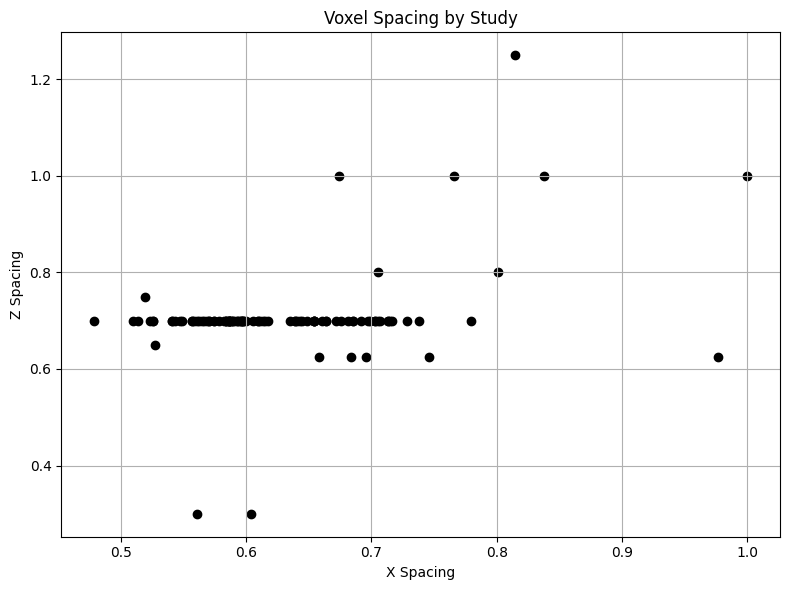

In [10]:
# Extract x and z spacings
x_spacings = [spacing[0] for spacing in voxel_spacings]
z_spacings = [spacing[2] for spacing in voxel_spacings]
labels = list(nested_dict.keys())


# Define colors for each key
colors = plt.cm.tab10(range(len(labels)))  # Use a colormap (10 colors max)

# Create the plot
plt.figure(figsize=(8, 6))
for i, key in enumerate(labels):
    plt.scatter(x_spacings[i], z_spacings[i], color='k', label=key)

# Add labels and legend
plt.xlabel("X Spacing")
plt.ylabel("Z Spacing")
plt.title("Voxel Spacing by Study")
#plt.legend(title="Studies", loc="upper left", bbox_to_anchor=(1, 1))  # Color-coded legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for readability
plt.show()

### Plot the image intensity

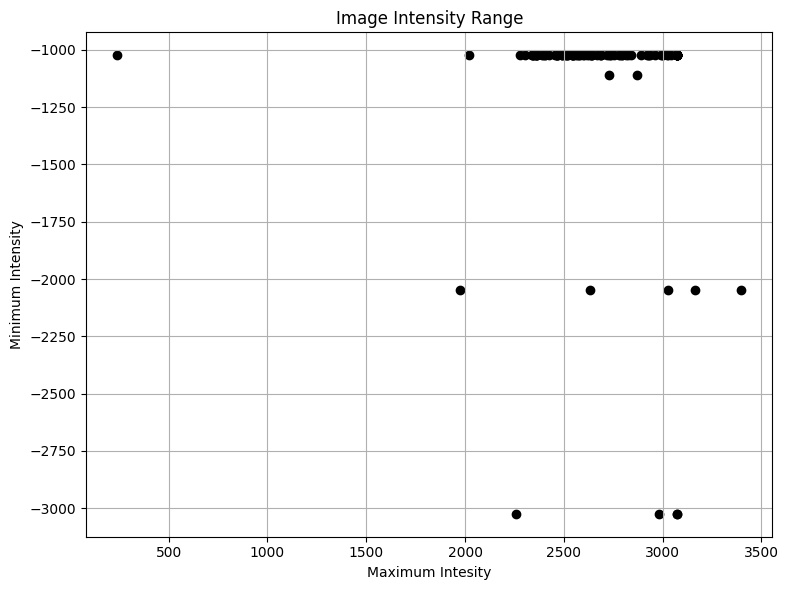

In [11]:
intensities = [sub_dict["Intensity Range"] for sub_dict in nested_dict.values()]

min_intense = [intense[0] for intense in intensities]
max_intense = [intense[1] for intense in intensities]

# Define colors for each key
colors = plt.cm.tab10(range(len(labels)))  # Use a colormap (10 colors max)

# Create the plot
plt.figure(figsize=(8, 6))
for i, key in enumerate(labels):
    plt.scatter(max_intense[i], min_intense[i], color='k', label=key)

# Add labels and legend
plt.xlabel("Maximum Intesity")
plt.ylabel("Minimum Intensity")
plt.title("Image Intensity Range")
#plt.legend(title="Studies", loc="upper left", bbox_to_anchor=(1, 1))  # Color-coded legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for readability
plt.show()